# MetaCLIP Dataset Creation

In this notebook, we mirror the method of [MetaCLIP](https://arxiv.org/pdf/2309.16671) to create a rebalanced version of the ImageNet-Captions 250k dataset.

In [1]:
import json
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In order to do this, we have to re-interpret the method slightly to consider $(X, Y)$ pairs where $X$ is an text pair (or nested image-text pair), and $Y$ is an "entry" or keyword phrase which is used to search captions. A caption can be matched with multiple entries (and vice versa). We make the choice to consider a text-entry pair to be a single datum, as the distribution that is considered in MetaCLIP is a distribution over entries. However, when we are in the multi-label setting (as are the authors of MetaCLIP), this is difficult to work with because the distribution is over the set of entry labels taken from all examples.

Set `DATA_PATH` to the desired location below.

In [2]:
# true numbers based on the ImageNet-Captions dataset
N_ENTRIES = 500000
N_CAPTIONS = 174594

# miniature numbers for illustration or testing
# N_ENTRIES = 10000 
# N_CAPTIONS = 10000

NUM_CLASSES = 250
DATA_PATH = f'/mnt/ssd/ronak/datasets/rebalanced_imagenet_captions_{NUM_CLASSES}k'

## Load ImageNet-Captions Dataset and MetaCLIP Metadata

Select a random subset of the entries used to match captions. The `metadata.json` is taken from the authors, which includes the keywords (entries) used to search the initial captions.

In [3]:
with open("../data/metadata.json") as f:
    metadata = json.load(f)

np.random.seed(123)
metadata = np.array(metadata)[np.random.choice(len(metadata), N_ENTRIES, replace=False)]
print(len(metadata))
print(metadata[:min(30, N_ENTRIES)])

500000
['Piyawee Ruenjinda' 'walkout' 'sjd' 'Gary Cahill' 'gogra' 'kościół'
 'pasquier' 'phayre' 'ssac' 'orsi' 'universalist' 'tenayuca'
 'nilaimozhi iiRu' "film's" 'viby' 'Pikkuoravien joululaulu' 'hazels'
 'Sonnet 18' 'BMW Championship (PGA Tour)' 'kendra' '033747 Marzahna'
 'Greg Olsen (American football)' 'David Wallace-Wells' 'lakkundi'
 'stipules' 'rupicapra' 'Mawaan Rizwan' 'Kelly Graves'
 'Dead code elimination' 'Wunderwaffe']


In `load_dir` specify the location of the original ImageNet-Captions dataset stored on your system (i.e., the output of `notebooks/create_imagenet_captions.ipynb`).

In [4]:
load_dir = f'/mnt/ssd/ronak/datasets/imagenet_captions_{NUM_CLASSES}k'
train_df = pd.read_csv(os.path.join(load_dir, f"imagenet_captions_train_c{NUM_CLASSES}.csv"), header=0, sep="\t")
val_df = pd.read_csv(os.path.join(load_dir, f"imagenet_captions_val_c{NUM_CLASSES}.csv"), header=0, sep="\t")

train_df

,title,filepath
0,120-2060_IMG,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
1,127-2701_IMG,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
2,Tusker,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
3,Old Tusker,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
4,IMG_0031,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
...,...,...
174589,Royal Albatross (Northern),/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174590,albatross,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174591,mollymawk 3,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174592,Laysan albatross w/ chick,/mnt/ssd/ronak/datasets/imagenet_captions_250k...


In [5]:
np.random.seed(123)
sample_space = np.unique(train_df['title'].to_numpy())
captions = sample_space[np.random.choice(len(sample_space), min(N_CAPTIONS, len(sample_space)), replace=False)]
print(len(captions))
print(captions[:min(30, N_CAPTIONS)])

125457
['100_2017' 'Geyser with Rainbow' 'IMG_1535' 'Barn cat' 'Surburban Pickup'
 'ampersand embroidery' "'insane clustrofobie'" 'Pinwheel cardigan'
 'old ladles' 'pomPas expO' 'Black hen' 'Blue circus pillow - reverse'
 'Tangerines' 'Tricera-body' 'Chapter Apron' 'DSC_0713' 'Run free'
 'Path Monkey, Zimbabwe' 'P4244156' 'Amsterdam Geese'
 'Day 124- Macro Monday' 'Rocky Mountain Bighorn Sheep Ram'
 'Leaderfoot Viaduct over the River Tweed'
 'pillow cover 2 :: dots + seeds (front)' 'P8310028' 'Common Starling'
 'Small Fly Macro' 'Sombrero - Supersized!'
 'Dorytomus longimanus female or D.taeniatus DSCF0059' 'hanky and garter']


## Perform Substring Matching

We generate our reference matrix by checking, for each caption, how many entries are matched. We then split and consider these to be different training examples.

In [6]:
!pip install pyahocorasick
import ahocorasick

In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates

automaton = None
spaced_metadata = None

def initialize_automaton(metadata):
    automaton = ahocorasick.Automaton()
    for idx, key in enumerate(spaced_metadata):
        automaton.add_word(key, (idx, key))
    automaton.make_automaton()
    return automaton

def spacing(text):
    puncts_to_wrap = [",", ".", ";", ":", "?", "!", "`"]
    chars_to_space = ["\t", "\n", "\r"]

    spaced_text = f" {text} "
    for punct_to_wrap in puncts_to_wrap:
        spaced_text = spaced_text.replace(
            punct_to_wrap, f" {punct_to_wrap} "
        )
    for char_to_space in chars_to_space:
        spaced_text = spaced_text.replace(char_to_space, " ")
    return spaced_text


def substr_matching(text, metadata):
    global spaced_metadata, automaton
    if spaced_metadata is None:
        spaced_metadata = [f" {entry} " for entry in metadata]
    text = spacing(text)
    if automaton is None:
        automaton = initialize_automaton(metadata)
    matched_entry_ids = set()
    for end_index, (entry_id, original_value) in automaton.iter(text):
        matched_entry_ids.add(entry_id)
    return list(matched_entry_ids)

In [8]:
matched_ids = {}
captions_per_entry = np.zeros(N_ENTRIES).astype(int)
reindex_captions = []
text_captions = []
for i, text in tqdm(enumerate(captions)):
    ids = substr_matching(text, metadata)
    if len(ids) > 0:
        matched_ids[text] = ids
        reindex_captions.append(i)
        text_captions.append(text)
        for entry in ids:
            captions_per_entry[entry] += 1

print(f"{len(matched_ids)}/{len(captions)} ({len(matched_ids)/len(captions):0.3f}) captions have matches.")

125457it [00:02, 55445.69it/s] 

87235/125457 (0.695) captions have matches.


In [9]:
for caption in text_captions[0:20]:
    print(f"{caption} : {[metadata[j] for j in matched_ids[caption]]}")

Geyser with Rainbow : ['with', 'Rainbow']
Barn cat : ['cat']
ampersand embroidery : ['embroidery', 'ampersand']
Pinwheel cardigan : ['cardigan']
old ladles : ['old', 'ladles']
Black hen : ['Black', 'hen']
Blue circus pillow - reverse : ['Blue', 'pillow', 'circus', 'reverse']
Run free : ['free']
Path Monkey, Zimbabwe : ['Monkey', 'Zimbabwe']
Amsterdam Geese : ['Amsterdam']
Day 124- Macro Monday : ['Day']
Rocky Mountain Bighorn Sheep Ram : ['Rocky', 'Mountain', 'Sheep']
Leaderfoot Viaduct over the River Tweed : ['the', 'River', 'over']
pillow cover 2 :: dots + seeds (front) : ['2', 'pillow', 'seeds', 'dots', 'cover']
Small Fly Macro : ['Fly']
Dorytomus longimanus female or D.taeniatus DSCF0059 : ['taeniatus', 'longimanus', 'D', 'female', 'or']
hanky and garter : ['garter', 'and', 'hanky']
green lacewing Chrysopa carnea Rutland Water, UK August 2008 : ['August', 'Water', 'green', 'carnea', 'UK', 'green lacewing', 'lacewing']
Joy of a Connection : ['of', 'a']
The ubiquitous chakka ! : ['ub

Ultimately, the multi-label to single-label approximation is sufficient because most captions are matched to a unique entry.

In [10]:
entries_per_caption = np.array([len(matched_ids[caption]) for caption in text_captions])
print(entries_per_caption.mean())
print(np.median(entries_per_caption))
print(entries_per_caption.sum())
print(captions_per_entry.sum())
print(len(captions_per_entry))

2.400206339198716
2.0
209382
209382
500000


We generate a similar plot to Figure 2 in the MetaCLIP paper to select the cut-off point, usually called $t$.

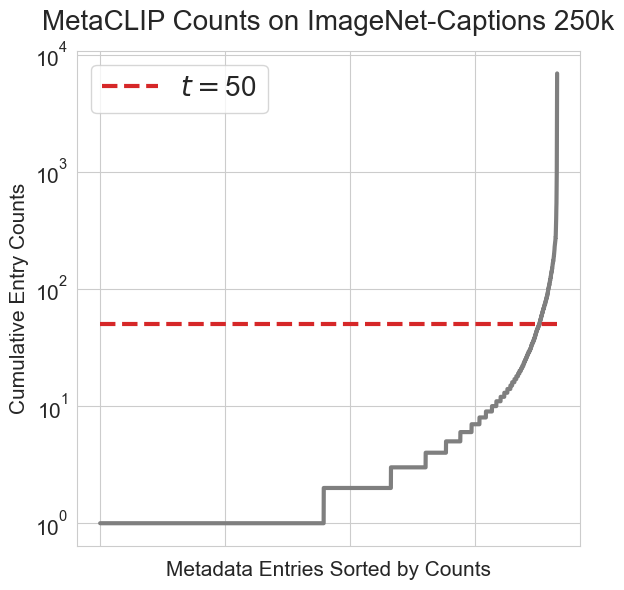

In [11]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

t = 50

counts = captions_per_entry[captions_per_entry != 0]
y = np.sort(counts)
x = np.arange(len(y))
ax.plot(x, y, color="tab:gray")
ax.hlines(y=t, xmin=0, xmax=len(counts), color="tab:red", linestyle="--", label=r"$t =$" + f"{t}")

ax.set_yscale("log")

ax.legend(loc="upper left")
ax.set_xticklabels([])
ax.set_xlabel("Metadata Entries Sorted by Counts")
ax.set_ylabel("Cumulative Entry Counts")
ax.set_title("MetaCLIP Counts on ImageNet-Captions 250k", pad=15.0)
fig.tight_layout()
plt.show()

In [12]:
# inspect most common entries

rank2idx = np.argsort(captions_per_entry)

for i in range(1, 11):
    print(f"{i}: {metadata[rank2idx[-i]]}")

1: the
2: and
3: in
4: of
5: on
6: a
7: The
8: at
9: with
10: 2


## Create Reference Matrix

Finally, we create an entries-by-captions matrix as the reference matrix that gets rebalanced.

In [13]:
observed_entries = np.arange(len(captions_per_entry))[captions_per_entry != 0]
reindex_entry = {entry: i for i, entry in enumerate(observed_entries)}
len(reindex_entry)

observed_captions = np.array(reindex_captions)

print(len(observed_captions))
print(len(text_captions))
print(len(matched_ids))

87235
87235
87235


In [14]:
mat = np.zeros(shape=(len(observed_captions), len(observed_entries))).astype(int)
for i, caption in enumerate(text_captions):
    ids = matched_ids[caption]
    for j in ids:
        mat[i, reindex_entry[j]] += 1

print(mat.sum())
print(captions_per_entry.sum())
print(entries_per_caption.sum())
print(mat.shape)

209382
209382
209382
(87235, 18300)


In [16]:
# use uniform marginal for X so that one example is alloted to each row
pmat = mat / mat.sum(axis=1)[:, None]

# normalize so the whole thing is a probability measure
pmat = pmat / pmat.sum()

# compute the marginal over entries
entry_marginal = pmat.sum(axis=0)

# compute desired marginal based on cutoff
t = 50
entry_counts = mat.sum(axis=0)
cy = entry_counts.copy()
cy[cy >= t] = t
py = cy / cy.sum()

In [17]:
np.save("../data/observed_entry_marginal.npy", entry_marginal)
np.save("../data/rebalanced_entry_marginal.npy", py)

## Create Rebalanced Training Set

We now sample the data according to the balanced probability mass matrix to generate the dataset.

In [18]:
# rescale 
pmat1 = pmat * (py / entry_marginal)[None, :]
pmat1 = pmat1 / pmat1.sum() # renormalize for numerical reasons

n = len(train_df)
caption_marginal = pmat1.sum(axis=1)
print(caption_marginal.shape)

(87235,)


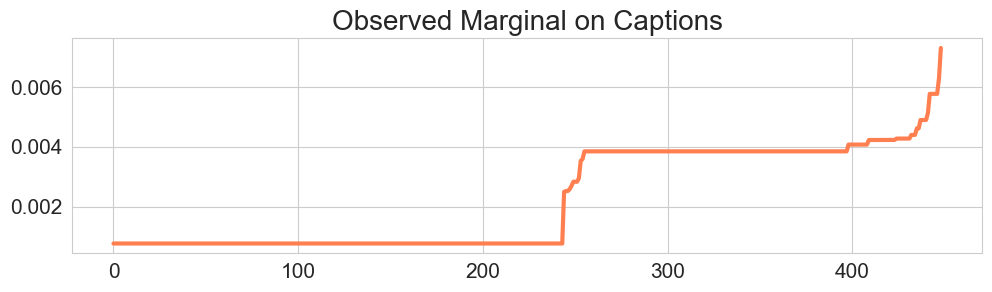

In [33]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

x = np.arange(len(caption_marginal))

ax.plot(x, np.sort(caption_marginal), color="coral")

ax.set_title("Observed Marginal on Captions")
fig.tight_layout(pad=1.0)
plt.show()

In [19]:
np.random.seed(123)
samples = np.random.choice(reindex_captions, size=(n,), p=caption_marginal, replace=True)

# new dataset
train_df1 = train_df.iloc[samples, :]

train_df1.to_csv(os.path.join(DATA_PATH, "metaclip_rebalanced_train_df.csv"), index=False, sep="\t")

## Generate Embeddings

This part of the notebook can be run independently after the first part has run, i.e. the example indices of the rebalanced dataset from the previous cell is saved. Finally, we generate embeddings of the datapoints identified above to be used in training runs.

In [42]:
import pandas as pd
import os
import torch
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn

import open_clip
from training.data import get_data, CsvDataset
from training.params import parse_args
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

In [40]:
NUM_CLASSES = 250
DATA_PATH = f'/mnt/ssd/ronak/datasets/rebalanced_imagenet_captions_{NUM_CLASSES}k'


df1 = pd.read_csv(os.path.join(DATA_PATH, "metaclip_rebalanced_train_df.csv"), sep="\t")
df1

,title,filepath
0,KG4-031L,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
1,Trafalgar Bookshop,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
2,Lion cub Zenda getting ready to yawn,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
3,03,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
4,Bittern11Mar21_2008,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
...,...,...
174589,Guacamole at That Burrito Place,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174590,PRC Abarth Pedrazza Racing Cars :: eu-moto © E...,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174591,P1019299,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174592,Two boxers,/mnt/ssd/ronak/datasets/imagenet_captions_250k...


Set the device below.

In [44]:
MODEL_NAME = "vit_b32_laion2b"
DEVICE = 'cuda:3'

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(DEVICE)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

print("Log scale:", model.logit_scale)
print("Scale:", model.logit_scale.exp())

Log scale: Parameter containing:
tensor(4.6052, device='cuda:3', requires_grad=True)
Scale: tensor(100., device='cuda:3', grad_fn=<ExpBackward0>)


In [46]:
params = [
    "--train-data", os.path.join(DATA_PATH, "metaclip_rebalanced_train_df.csv"),
    "--val-data", f"imagenet_captions_250k/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False

# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvDataset(
    input_filename,
    preprocess_train,
    img_key=args.csv_img_key,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
    tokenizer=tokenizer,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

dataloader = DataLoader(
    dataset,
    batch_size=1024,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False,
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

As in `notebooks/create_imagenet_captions.ipynb`, we test the dataloader by observing an image and caption pair example.

torch.Size([1024, 3, 224, 224])
torch.Size([1024, 77])


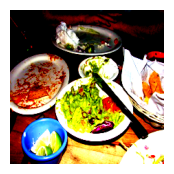

<start_of_text>remainder of guacamole <end_of_text>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [47]:
for i, batch in enumerate(dataloader):
    idx, images, texts = batch
    break

print(images.shape)
print(texts.shape)

batch_id = 0

# show image from dataloader
img = images[batch_id].numpy().transpose([1, 2, 0])
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

# show decoded text from dataloader
txt = texts[batch_id]
print(tokenizer.decode([elem.item() for elem in txt]))

In [ ]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy")):
    print("found embeddings - loading...")
    all_image_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"))
    all_text_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    all_image_features, all_text_features, all_idx = [], [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, images, texts = batch
            image_features = model.encode_image(images.to(DEVICE))
            text_features = model.encode_text(texts.to(DEVICE))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
            all_idx.append(idx)
            
    all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
    all_text_features = torch.cat(all_text_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"), all_image_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"), all_text_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_image_features.shape)
print(all_text_features.shape)
print(all_idx.shape)